In [2]:
# 0. IMPORT THƯ VIỆN (NÂNG CAO)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [3]:
# 1. BUSINESS UNDERSTANDING
print("""
Mục tiêu nâng cao:
- Tạo pipeline CRISP-DM với nhiều mô hình khác nhau.
- Trực quan hóa dữ liệu (EDA).
- Đánh giá nhiều mô hình bằng Accuracy, AUC.
- Tìm mô hình tốt nhất và giải thích Feature Importance.
""")


Mục tiêu nâng cao:
- Tạo pipeline CRISP-DM với nhiều mô hình khác nhau.
- Trực quan hóa dữ liệu (EDA).
- Đánh giá nhiều mô hình bằng Accuracy, AUC.
- Tìm mô hình tốt nhất và giải thích Feature Importance.



In [4]:
# 2. DATA UNDERSTANDING
df = pd.read_csv("customer_churn.csv")
display(df.head())
display(df.info())
df.describe()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


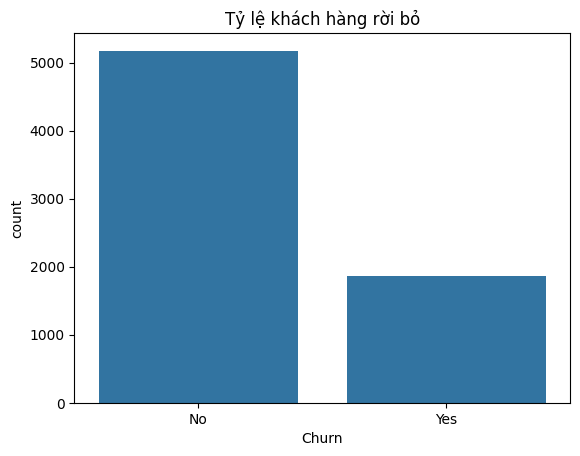

In [5]:
# EDA 1: Phân bố churn
sns.countplot(data=df, x="Churn")
plt.title("Tỷ lệ khách hàng rời bỏ")
plt.show()

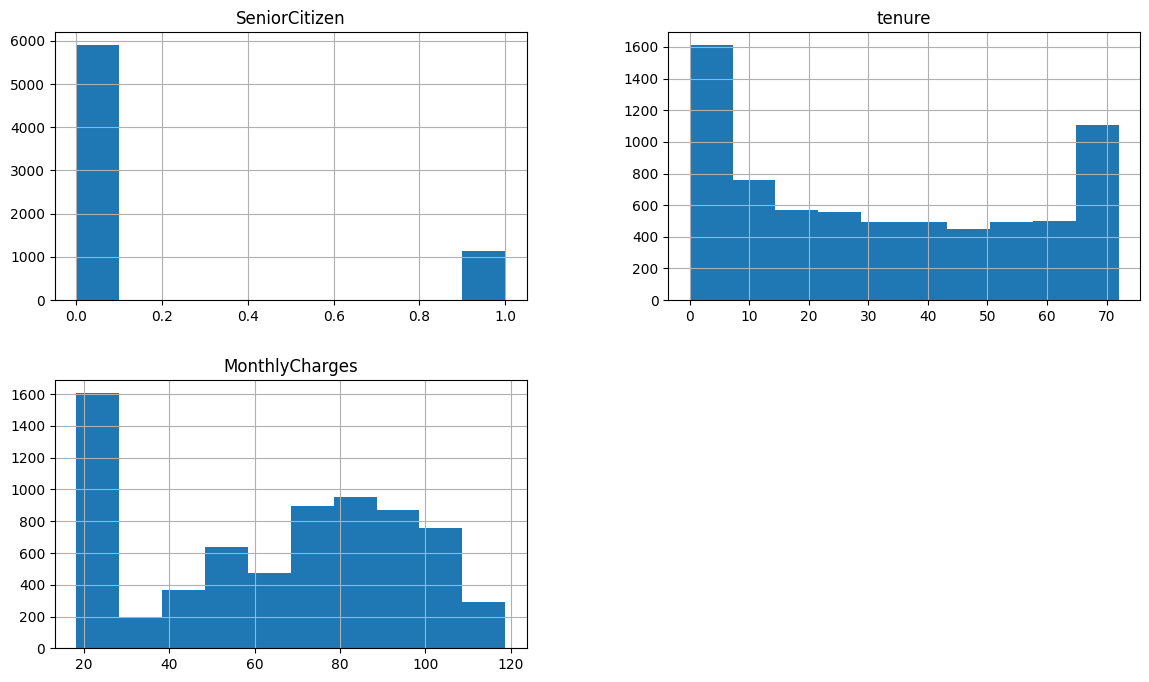

In [6]:
# EDA 2: Histogram cho numeric
df.hist(figsize=(14,8))
plt.show()

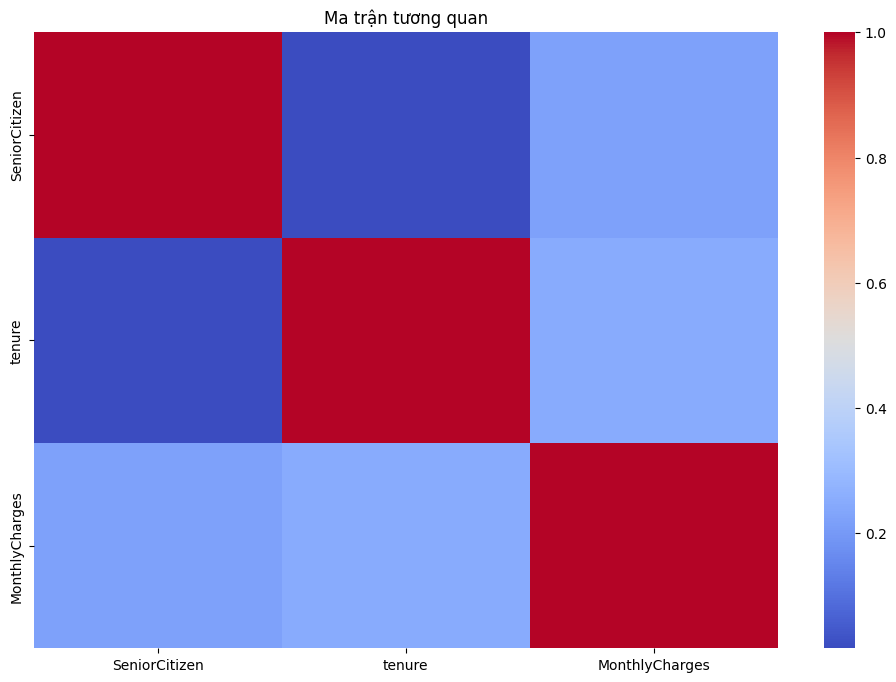

In [7]:
# EDA 3: Heatmap tương quan
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Ma trận tương quan")
plt.show()

In [8]:
# 3. DATA PREPARATION (NÂNG CAO)
df_clean = df.copy()

if "customerID" in df_clean.columns:
    df_clean.drop("customerID", axis=1, inplace=True)

df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
df_clean['TotalCharges'].fillna(df_clean['TotalCharges'].median(), inplace=True)

cat_cols = df_clean.select_dtypes(include=["object"]).columns
encoder = LabelEncoder()
for col in cat_cols:
    df_clean[col] = encoder.fit_transform(df_clean[col])

X = df_clean.drop("Churn", axis=1)
y = df_clean["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [9]:
# 4. MODELING (TẠO NHIỀU MÔ HÌNH)
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "SVM RBF": SVC(probability=True)
}

results = {}

for name, model in models.items():
    model.fit(X_train_s, y_train)
    pred = model.predict(X_test_s)
    prob = model.predict_proba(X_test_s)[:,1]

    results[name] = {
        "accuracy": accuracy_score(y_test, pred),
        "auc": roc_auc_score(y_test, prob)
    }

results

{'Logistic Regression': {'accuracy': 0.7991483321504613,
  'auc': 0.8402800382340025},
 'Decision Tree': {'accuracy': 0.7366926898509581, 'auc': 0.6677310186261594},
 'Random Forest': {'accuracy': 0.7913413768630234, 'auc': 0.8231160711979125},
 'SVM RBF': {'accuracy': 0.7934705464868701, 'auc': 0.7908767986773102}}

In [10]:
# 5. EVALUATION (SO SÁNH MÔ HÌNH)
res_df = pd.DataFrame(results).T
res_df

,accuracy,auc
Logistic Regression,0.799148,0.840280
Decision Tree,0.736693,0.667731
Random Forest,0.791341,0.823116
SVM RBF,0.793471,0.790877


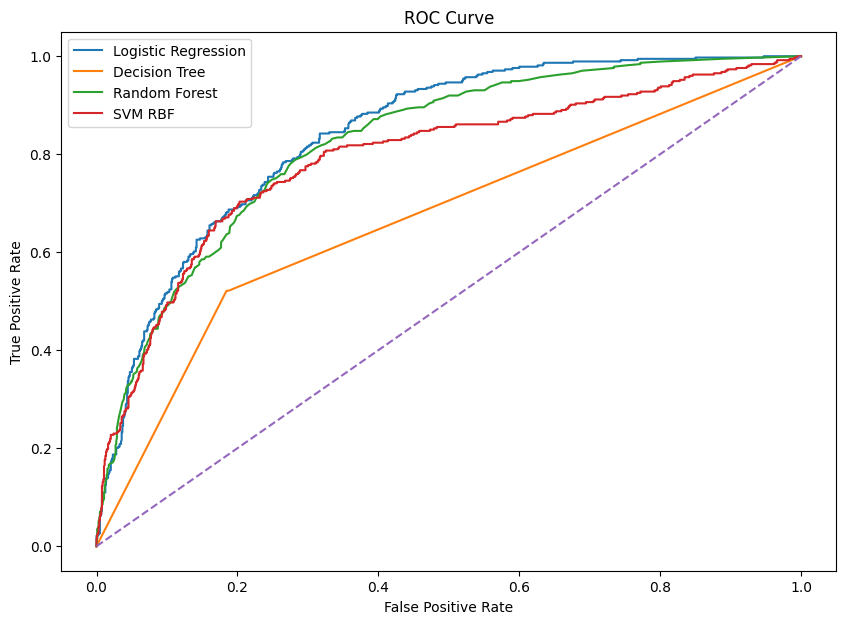

In [11]:
# Vẽ ROC cho 4 mô hình
plt.figure(figsize=(10,7))
for name, model in models.items():
    prob = model.predict_proba(X_test_s)[:,1]
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [12]:
# Feature importance từ Random Forest
rf = models["Random Forest"]
importances = rf.feature_importances_
fi = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

fi

,Feature,Importance
18,TotalCharges,0.188009
17,MonthlyCharges,0.176288
4,tenure,0.152371
14,Contract,0.079339
16,PaymentMethod,0.051011
8,OnlineSecurity,0.047899
11,TechSupport,0.046319
0,gender,0.028603
7,InternetService,0.028358
9,OnlineBackup,0.027727


C:\Users\USER\AppData\Local\Temp\ipykernel_6888\755147145.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi, x="Importance", y="Feature", palette="viridis")


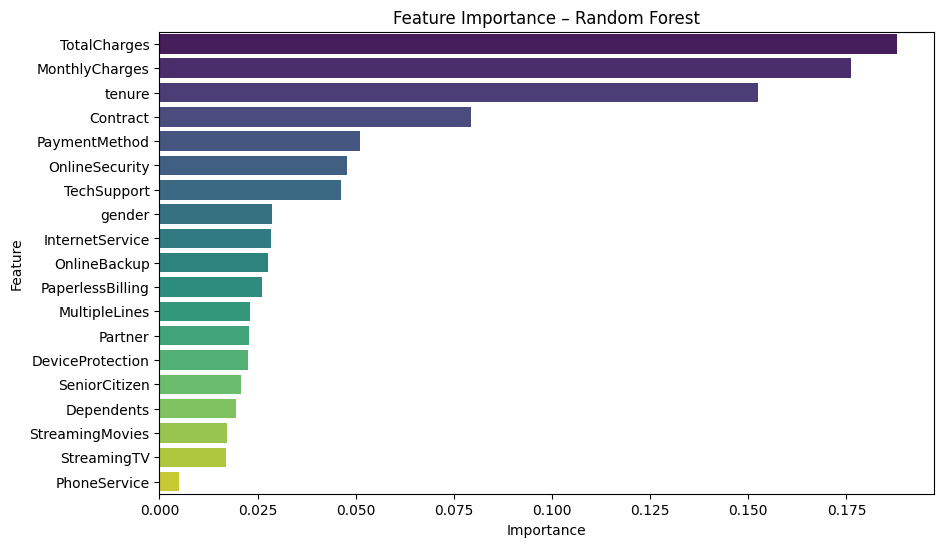

In [13]:
# Biểu đồ Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(data=fi, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance – Random Forest")
plt.show()

In [14]:
# 6. DEPLOYMENT (NÂNG CAO)
def predict_customer(data_dict):
    df_in = pd.DataFrame([data_dict])
    for c in df_in.columns:
        if c in cat_cols:
            df_in[c] = encoder.fit_transform(df_in[c])
    df_in = scaler.transform(df_in)
    model = models["Random Forest"]
    pred = model.predict(df_in)[0]
    return "Churn" if pred == 1 else "Stay"

print("Hàm dự đoán nâng cao đã sẵn sàng!")

Hàm dự đoán nâng cao đã sẵn sàng!
